# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.727420,True,4.436339
1,2.734727,True,12.126358
2,0.545277,True,4.064681
3,-0.189455,True,6.461159
4,0.950907,True,7.184694
...,...,...,...
995,-0.165533,True,5.859161
996,3.388491,True,11.644466
997,1.295054,True,7.350901
998,0.854074,False,1.827955


<AxesSubplot: xlabel='v0'>

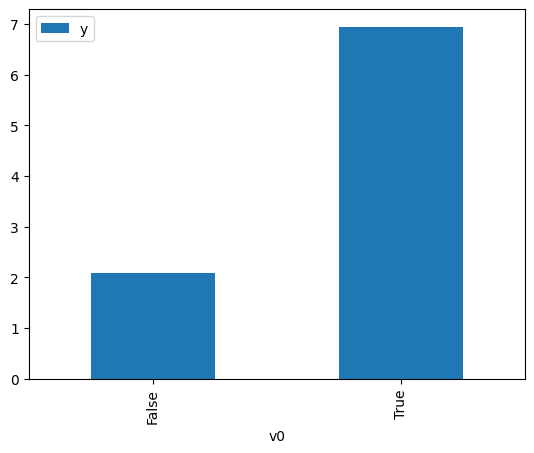

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

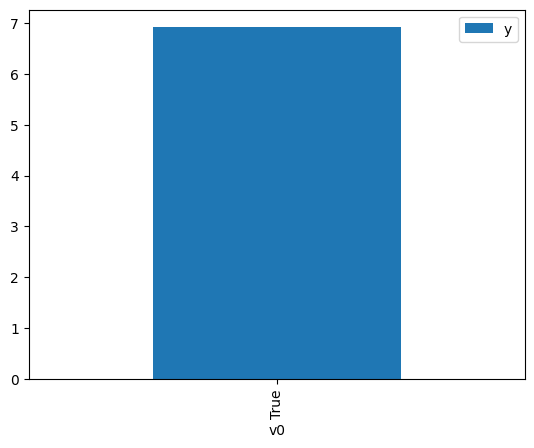

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.506601,False,-1.951679,0.621074,1.610113
1,0.944632,False,0.842246,0.222769,4.488963
2,-0.903366,False,-0.408792,0.725287,1.378765
3,0.494008,False,1.261760,0.330005,3.030256
4,-0.218463,False,-1.092038,0.536908,1.862516
...,...,...,...,...,...
995,3.413053,False,8.490188,0.014550,68.728841
996,0.407791,False,1.258398,0.353299,2.830462
997,-0.085650,False,0.931679,0.497080,2.011747
998,1.137395,False,1.402871,0.185244,5.398295


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.653216,True,7.223742,0.891000,1.122334
1,2.473292,True,10.067585,0.956326,1.045668
2,1.940161,True,7.554565,0.920252,1.086659
3,3.270203,True,11.846300,0.982773,1.017529
4,0.250453,True,6.602606,0.602411,1.659997
...,...,...,...,...,...
995,0.295529,True,4.045257,0.615308,1.625201
996,0.535804,True,5.944694,0.681002,1.468424
997,1.427571,True,8.345234,0.861747,1.160434
998,0.256970,True,6.866930,0.604285,1.654849


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          2.120e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:27:31   Log-Likelihood:                         -1456.5
No. Observations:                1000   AIC:                                      2917.
Df Residuals:                     998   BIC:                                      2927.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3185      0.035     65.493      0.000       2.249       2.388
x2             4.8981      0.057     86.244      0.000       4.787       5.010
==============================================================================
Omnibus:                        2.706   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.360
Skew:                           0.008   Prob(JB):                        0.307
Kurtosis:                       2.763   Cond. No.                         2.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""